# Treinamento do modelo usando imagens radiográficas

## Importando as bibliotecas

- OS: biblioteca para interação com sistema operacional
- SYS: biblioteca focada na interação com o interpretador do python
- TensorFlow: biblioteca para processamento de dados e contrução de CNN
- Keras: API de deep learining de alto nível executada sobre o TensorFlow
- JSON: biblioteca para codificação e decodificação de no formatpo JavaScript Object Notation

In [ ]:
import os
import sys
import tensorflow as tf
import keras
import json

## Definindo a localização dos dados

Verifica se o código está sendo rodado no Google Colab e, se sim, monta o drive no ambiente de execução e aponta a pasta raiz do projeto

In [ ]:
if "google.colab" in sys.modules:
    from google.colab import drive

    drive.mount("/content/drive")
    BASE_PATH = "/content/drive/MyDrive/classification-of-medical-images-using-cnn/"
else:
    BASE_PATH = os.path.abspath(os.path.join(os.getcwd(), ".."))

Mounted at /content/drive


- Armazena o local onde os dados de treino e validação estão presentes
- Armazena o local onde o modelo deve salvar o modelo já treinado, os pesos usados por ele e o histórico de treinamento e garante que seus respectivos diretórios existam

In [ ]:
TRAIN_DIR = os.path.join(BASE_PATH, "data", "train")
VAL_DIR = os.path.join(BASE_PATH, "data", "val")
MODEL_PATH = os.path.join(BASE_PATH, "models", "xray_images.keras")
MODEL_WEIGHTS_PATH = os.path.join(BASE_PATH, "models", "xray_images.weights.h5")
RESULT_PATH = os.path.join(BASE_PATH, "results", "xray_images.json")

os.makedirs(os.path.dirname(MODEL_PATH), exist_ok=True)
os.makedirs(os.path.dirname(RESULT_PATH), exist_ok=True)

## Definição de parâmetros gerais

- `IMAGE_SIZE`: tamanho para o qual as imagens serão resimensionadas para que o modelo possa analisar
- `BATCH_SIZE`: tamanho do lote de imagens que serão analisadas pelo modelo a cada interação
- `EPOCHS`: número de vezes que o modelo analisará todas as imagens do conjunto de treinamento
- `SEED`: indica como será feito o embaralhamento do conjunto de dados

In [4]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
SEED = 42

## Carregamento do dataset

- `image_size`: redimensiona as imagens
- `batch_size`: define o número de imagens por lote
- `label_mode`: separa todas as imagens em duas classes
- `shuffle`: define as imagens serão ou não embaralhadas
- `seed`: define como as imagens serão embaralhadas  

In [5]:
train_data = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=True,
    seed=SEED,
)

val_data = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary",
    shuffle=False,
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


##  Pré processamento das imagens

#### Noramalização

- `normalization_layer`: define para que os pixels da imagem sejam normalizados para valores entre 0 e 1

- Realiza a normalização nos conjuntos de treino e de validação

In [6]:
normalization_layer = keras.layers.Rescaling(1.0 / 255)

train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

#### Denfinindo e aplicando padrões de aumentação

- `RandomFlip`: inverte a imagem na horizontal aleatoriamente
- `RandomRotation`: gira a imagem aleatoriamente (0.05 equivale a até 5% da circunferência aprox. 18 graus)
- `RandomZoom`: amplia ou reduz na imagem aleatoriamente (0.1 equivale a até 10% do tamanho da imagem)

In [7]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.05),
        keras.layers.RandomZoom(0.1),
    ]
)

### Data augmentation

Realiza o data augmentation apenas no conjunto de teste

In [8]:
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))

## Otimização do desempenho

O AUTOTUNE permite que a biblioteca do TensorFlow decida sozinho quantos dados carregar com antecedência, quando carregar e quanto de paralelismo usar, para se ajustar automaticamente para o melhor desempenho no hardware disponível

In [9]:
AUTOTUNE = tf.data.AUTOTUNE

train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)

## Carregamento do Modelo Pré-treinado (transfer learning)

- Carrega o modelo base ResNet50 pré-treinada no Imagenet

- Congela as camadas da rede base

In [46]:
base_model = keras.applications.ResNet50(
    weights="imagenet", include_top=False, input_shape=(224, 224, 3)
)

base_model.trainable = False

## Construção do modelo final

Diz ao modelo que ele receberá imagens de 224X224 pixels com 3 canais de cor

In [47]:
inputs = keras.Input(shape=(224,224,3))

- `x`: representa os dados intermediários do processamento
- `training=False`: usdo para impedir instabilidades no treinamento ou destruição do conhecimento prévio do modelo pré-treinado. 

In [48]:
x = base_model(inputs, training=False)

Reduz a dimensionabilidade das características extraídas  pelo ResNet:
- A rede neural desenha vários mapas das características da imagem
- O `GlobalAveragePooling2D` tira a média de cada um destes mapas
- Reduz o número de parâmetros, melhora a generalização e diminui overfitting

In [49]:
x = keras.layers.GlobalAveragePooling2D()(x)

É uma camada de decisão
- Combina as características resumidas pelo `GlobalAveragePooling2D`, aprende as relações
- 128 indica o número de neurônios pelos quais as informações pasarão
  - números menores fazem o modelo decidir muito rápido, sem "raciocinar" direito
  - números maiores podem tornar o modelo pesado demais, além de poderem fazer ele "se confundir"
- O ReLU (Rectified Linear Unit) age como um filtro de relevância
  - valores negativos são transformados em zero - informações
  - valores ppositivos são mantidos

In [50]:
x = keras.layers.Dense(128, activation="relu")(x)

Outra camada de decisão
- O valor 1 indica que deve haver apenas uma saída
- O `sigmoid` faz o modelo decidir entre uma resposta binária
  - 0.34 vira 0
  - 0.73 vira 1

In [51]:
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

Informa ao modelo quais tipos de dados serão sua entrada e o tipo de saída esperada após o processamento, ele automaticamente conecta todas as epatas itermediárias

In [52]:
model = keras.models.Model(inputs, outputs)

## Compilação do Modelo

- `optimizer` indica ao modelo como ajustar seus erros
  - Adam é um otimizador rápido e estável, bom para a maioria dos problemas
- `loss` é uma forma de medir o quão longe o modelo estava da resosta certa
  - `binary_crossentropy` é usada quando há duas classes e a saída é uma probabilidade entre 0 e 1
  - Pune mais erros confiantes que erros "em dúvida"
- `metrics` permite a acompanhar o desempenho do modelo, se ele está realmente aprendendo
  - `accuracy` mede quantas previsões do total o modelo acertou:
  $$ \frac{número \, de \, acertos}{total \, de \, previsões} $$


In [53]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

## Treinamento do modelo

Indica ao modelo o conjunto de treinamento, de validação e o número de épocas (quantas vezes o modelo vê todo o conjunto de dados)

In [54]:
history = model.fit(train_data, validation_data=val_data, epochs=EPOCHS)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.7249 - loss: 0.5599 - val_accuracy: 0.5625 - val_loss: 0.7318
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 91ms/step - accuracy: 0.7807 - loss: 0.4393 - val_accuracy: 0.6250 - val_loss: 0.6902
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 90ms/step - accuracy: 0.8155 - loss: 0.3898 - val_accuracy: 0.6250 - val_loss: 0.6973
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8294 - loss: 0.3669 - val_accuracy: 0.6250 - val_loss: 0.6901
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8354 - loss: 0.3500 - val_accuracy: 0.6250 - val_loss: 0.6885
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.8429 - loss: 0.3354 - val_accuracy: 0.6250 - val_loss: 0.6813
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.8496 - loss: 0.3229 - val_accuracy: 0.6250 - val_loss: 0.6723
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 15s 89ms/step - accuracy: 0.8577 - loss: 0.3106 -

## Salvando o modelo em disco 

Salva o modelo já treinado

In [55]:
model.save(MODEL_PATH)

Salva os pesos atribuídos pelo modelo

In [56]:
model.save_weights(MODEL_WEIGHTS_PATH)

Salva o histórico do treinamento como um arquivo no formato JSON

In [57]:
history_dict = history.history

with open(RESULT_PATH, "w") as f:
    json.dump(history_dict, f)

## Visualização da curva de acurácia e de loss

- Usa a biblioteca Matplot para geração de imagens
- `plt.figure`: define uma figura (janela) e controla o tamanho que ela vai aparecer na tela
- `plt.subplot`: define que será uma grade com 1X2 gráficos e o índice da sub-imagem
- `plt.plot`: mostra uma linha com os valores fornecidos
- `plt.tile`: mostra o título do gráfico
- `plt.legend`:  mostra a legenda indicando as linhas do gráfico
- `plt.show`: mostra o gráfico na tela

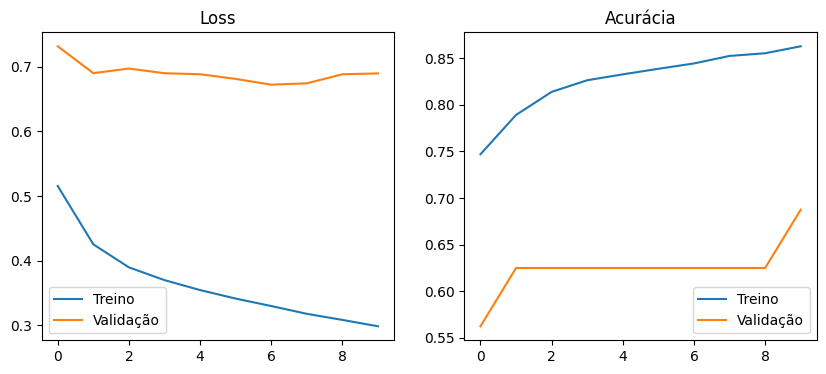

In [58]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_dict['accuracy'])
plt.plot(history_dict['val_accuracy'])
plt.title('Acurácia')
plt.legend(['Treino', 'Validação'])

# Loss
plt.subplot(1,2,1)
plt.plot(history_dict['loss'])
plt.plot(history_dict['val_loss'])
plt.title('Loss')
plt.legend(['Treino', 'Validação'])


plt.show()